## Camera Calibration
***
#### NOTE: This code was written to be used with the calibration images from Udacity's Project 2: Advanced Lane Finding to undistort images in "P2.ipynb"
***
This code will output the matrix and distortion coefficients which is necessary to correct the camera distortion in any image that was created using this camera. The distortion is the result of transforming 3D objects into a 2D image. The calibration data will be used to undistort each frame of the video before any processing is performed. 

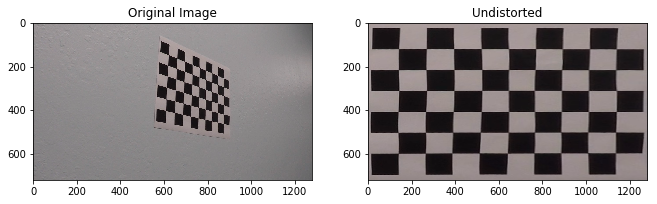

In [20]:
# Import packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import pickle
%matplotlib inline

# Import all calibration images 
images = glob.glob('camera_cal/calibration*.jpg')
image1 = cv2.imread(images[1])

#### CAMERA CALIBRATION FUNCTIONS ####
# Find corners of chessboards in calibration images
def find_corners():
    ''' Finds corners of the chessboard in all calibration images '''
    fig, ax = plt.subplots(5,4, figsize=(16, 11))
    ax = ax.ravel()

    # Prepare matrix to store object points
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    # Prepare array for object and image points
    obj_p = []
    img_p = []

    # Loop through calibration images to find chessboard corners
    for f, fname in enumerate(images):
        img = cv2.imread(fname)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray,(9, 6), None)
        # If found, append object points, image points and draw corners
        if ret == True:
            obj_p.append(objp)
            img_p.append(corners)
            # Draw and display the corners
            img_corners = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            # Visualization
            ax[f].imshow(img_corners)
    # Save figure of detected corners
    fig.savefig('camera_cal/find_corners.png')
    plt.close(fig)
    return obj_p, img_p

def cal_unwarp(img, mtx, dist):
    """
    This function will unwarp an input image using the result of the calibrateCamera()
    function (used to calibrate the camera) and correct the disortion created by the
    camera lenses. This function will output a figure displaying results of all
    calibration images to verify the calibration matrix and distortion coeffiecients
    successfully undistorted the image and warped the image to display the chessboard. 
    """    
    # Create an empty array for the matrix and the corrected image
    M = []
    warped = np.zeros_like(img)
    nx = 9  # number of inside corners in x
    ny = 6  # number of inside corners in y

    undist = cv2.undistort(img,mtx,dist,None,mtx)

    # Convert to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If corners found, warp image using warpPerspective()
    if ret is True:
        # draw corners on image
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # define 4 source points src = np.float32([[,],[,],[,],[,]])
        src = np.float32([corners[0],corners[nx-1],corners[-nx],corners[-1]])
        # define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        square_size_x = img.shape[1]/nx
        square_size_y = img.shape[0]/ny
        dst = np.float32([[square_size_x,square_size_y],
                          [img.shape[1]-square_size_x,square_size_y],
                          [square_size_x,img.shape[0]-square_size_y],
                          [img.shape[1]-square_size_x,img.shape[0]-square_size_y]])

        # use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # use cv2.warpPerspective() to warp your image to a top-down view
        img_size = (img.shape[1], img.shape[0])
        warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M

#### FIND CORNERS ####
objpoints, imgpoints = find_corners()

#### CALIBRATE CAMERA ####
ret,mtx,dist,rvec,tvec = cv2.calibrateCamera(objpoints,imgpoints,image1.shape[1::-1],None,None)

# Create ".p" file to store calibration matrix ('mtx') and distortion coefficients ('dist')
dict_pickle = {"mtx":mtx,"dist":dist}
pickle.dump(dict_pickle, open("calibration_data.p", "wb"))

# Visualization
# Create figure to display results
fig, ax = plt.subplots(5,4, figsize=(16, 11))

ax = ax.ravel()

#### CORRECT CAMERA DISTORTION ####
for f, fname in enumerate(images):
    img = cv2.imread(fname)
    warped, M = cal_unwarp(img, mtx, dist)
    ax[f].imshow(warped)

# Visualization
fig.savefig('camera_cal/warped_calibration.png')
# plt.close(fig)
